In [1]:
import json
from allennlp.models import archival

from models.predictor import DialogQAPredictor
from models.dialog_qa_ctx import DialogQA
from models.readers import QuACReader
from allennlp.common.params import Params

In [2]:
EXP_NAME = 'ant_TRUE__men_TRUE__k1__c_uniform'
MODEL_PATH = '/Users/sohamghosh/Documents/CMU/Courses/quac/exp_dir/'
NUM_TURNS = 1

def from_archive(archive):
    config = archive.config.duplicate()
    dataset_reader_params = config["dataset_reader"]
    dataset_reader_params.pop('type')
    dataset_reader = QuACReader.from_params(dataset_reader_params)
    model = archive.model
    model.eval()
    return DialogQAPredictor(model, dataset_reader)

In [3]:
import os

archive = archival.load_archive(os.path.join(MODEL_PATH, EXP_NAME, 'model.tar.gz'))
predictor = from_archive(archive)

INIT MODEL


In [4]:
data = json.load(open('./data/val-small.json'))['data']

In [5]:
% matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

def plot_attention(attn, y_labels, x_labels, figsize):
    plt.figure(figsize=figsize)
    fig, ax1 = plt.subplots(1,1, figsize=figsize)
    attn = attn[:len(y_labels), :len(x_labels)]
    heatmap = ax1.imshow(attn, cmap="magma", interpolation='nearest')
    ax1.set_xticks(np.arange(len(x_labels)))
    ax1.set_yticks(np.arange(len(y_labels)))
    if x_labels is not None and y_labels is not None:
        ax1.set_xticklabels(x_labels)
        ax1.set_yticklabels(y_labels)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    plt.colorbar(heatmap)
    plt.show()

In [6]:
def get_results(ex, predictor):
    for qa in ex['paragraphs'][0]['qas']:
        qa['answer'] = qa['orig_answer']['text']
        qa['answer_start'] = qa['orig_answer']['answer_start']
    return predictor.predict_instance(predictor._json_to_instance([ex]))

In [15]:
EXAMPLE_IX = 1
pred = get_results(data[EXAMPLE_IX], predictor)

21
13
13
13
13
13
13
13
13
21
21
21
21
21
21
21
21


/anaconda3/lib/python3.6/site-packages/torch/tensor.py:263: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [9]:
weights_qa = np.array(pred['weights_qa'])
weights_qq = np.array(pred['weights_qq'])
sm_att_as = np.array(pred['sm_att_as'])
sm_att_qs = np.array(pred['sm_att_qs'])
passage_question_attention = np.array(pred['passage_question_attention'])

{'title': 'The murder remains unsolved, 2016',
 'paragraphs': [{'context': 'In September 2016 Vladimir Markin, official spokesman for the Investigative Committee, included the killing of Anna Politkovskaya among the Most Dramatic Crimes in 21st century Russia and claimed that it had been solved. Her colleagues at Novaya gazeta protested that until the instigator or sponsor of the crime was identified, arrested and prosecuted the case was not closed. On 7 October 2016 Novaya gazeta released a video clip of its editors, correspondents, photographers and technical and administrative staff holding text-boards giving details of the case and stating, repeatedly, "The sponsor of Anna\'s murder has not been found". On the same day deputy chief editor Sergei Sokolov published a damning summary of the official investigation, describing its false turns and shortcomings, and emphasised that it had now effectively been wound up. After the three Makhmudov brothers, Khadjikurbanov and Lom-Ali Gaituka

 TURN : 1 
 TURN : 2 
 TURN : 3 
 TURN : 4 
 TURN : 5 
 TURN : 6 
Question (t-1) attention


<Figure size 576x576 with 0 Axes>

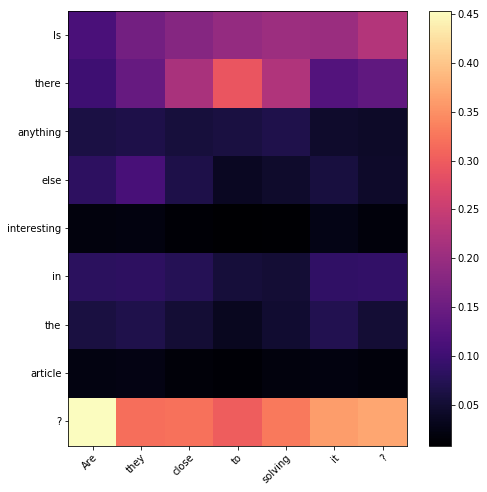

 TURN : 7 


In [18]:
import numpy as np

followups = np.array([qa['followup'] for qa in data[EXAMPLE_IX]['paragraphs'][0]['qas']])
for turn in range(1, sm_att_qs.shape[1]):
    print(""" TURN : {} """.format(turn))
    for prev_turn in range(NUM_TURNS - 1, -1, -1):
        if np.all(followups[turn - prev_turn - 1:turn] == 'y'):
            print("Question (t-{}) attention".format(prev_turn + 1))
            _ = plot_attention(sm_att_qs[prev_turn, turn, :, :].T, pred['question_tokens'][turn - prev_turn - 1], pred['question_tokens'][turn], (8,8))


Answer (t-1) attention
(23, 9)


<Figure size 720x1008 with 0 Axes>

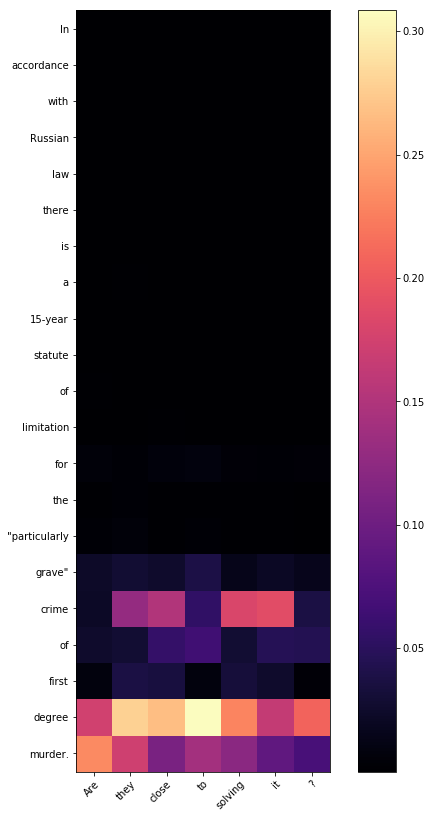

In [20]:
followups = np.array([qa['followup'] for qa in data[EXAMPLE_IX]['paragraphs'][0]['qas']])
for turn in range(1, sm_att_qs.shape[1]):
    for prev_turn in range(NUM_TURNS - 1, -1, -1):
        if np.all(followups[turn - prev_turn - 1:turn] == 'y'):
            print("Answer (t-{}) attention".format(prev_turn + 1))
            print(sm_att_as[prev_turn, turn, :, :].T.shape)
            _ = plot_attention(sm_att_as[prev_turn, turn, :, :].T, pred['answer_tokens'][turn - prev_turn - 1][0].split(), pred['question_tokens'][turn], (10,14))


In [12]:
if NUM_TURNS > 1:
    print("Hierarchical Attention")
    _ = plot_attention(weights_qa[:, turn, :],
                       ['t - ' + str(i + 1) for i in range(NUM_TURNS)],
                       pred['question_tokens'][turn],
                       (10,10))


    NUM_TURNS = weights_qa.shape[0]
    _ = plot_attention(weights_qq[:, turn, :],
                       ['t - ' + str(i + 1) for i in range(NUM_TURNS)],
                       pred['question_tokens'][turn],
                       (10,10))



## Metrics to get

1. % of time turn t - k gets highest attention score
2. histogram of num_followups in dialog snippets
3. 